# BNN_v1: original BNN

In [19]:
import numpy as np

import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchbnn as bnn

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [20]:
ck_dir=f'./checkpoint/OOD'
result_dir=f'result/OOD/BNN_v1'
ck_path=os.path.join(ck_dir, f'bnn_v1.pt')

os.makedirs(ck_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

## 1. Load Mnist

In [21]:
def getSets(filteredClass = None, removeFiltered = True) :
	"""
	Return a torch dataset. If removeFiltered = True, then return all rest class. Or it only returns one class.
	"""
	
	train = torchvision.datasets.MNIST('./data/', train=True, download=True,
								transform=torchvision.transforms.Compose([
										torchvision.transforms.ToTensor(),
										torchvision.transforms.Normalize((0.1307,), (0.3081,))
								]))

	test = torchvision.datasets.MNIST('./data/', train=False, download=True,
								transform=torchvision.transforms.Compose([
										torchvision.transforms.ToTensor(),
										torchvision.transforms.Normalize((0.1307,), (0.3081,))
								]))
	
	if filteredClass is not None :
		
		train_loader = torch.utils.data.DataLoader(train, batch_size=len(train))
		train_labels = next(iter(train_loader))[1].squeeze()
		test_loader = torch.utils.data.DataLoader(test, batch_size=len(test))
		test_labels = next(iter(test_loader))[1].squeeze()
		
		if removeFiltered : 
			trainIndices = torch.nonzero(train_labels != filteredClass).squeeze()
			testIndices = torch.nonzero(test_labels != filteredClass).squeeze()
		else :
			trainIndices = torch.nonzero(train_labels == filteredClass).squeeze()
			testIndices = torch.nonzero(test_labels == filteredClass).squeeze()
		
		train = torch.utils.data.Subset(train, trainIndices)
		test = torch.utils.data.Subset(test, testIndices)
	
	return train, test

In [22]:
train, test = getSets(filteredClass=4)
batch_size=64

train_loader = DataLoader(train, batch_size=64)
test_loader = DataLoader(test, batch_size=64)

## 2. Define Model

In [23]:
class BayesianMnistNet(nn.Module):
    def __init__(self):
        super(BayesianMnistNet, self).__init__()
        self.conv1 = bnn.BayesConv2d(prior_mu=0., prior_sigma=.1, in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = bnn.BayesConv2d(prior_mu=0., prior_sigma=.1, in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = bnn.BayesLinear(prior_mu=0., prior_sigma=.1, in_features=64 * 7 * 7, out_features=128)
        self.fc2 = bnn.BayesLinear(prior_mu=0., prior_sigma=.1, in_features=128, out_features=10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BayesianMnistNet().to(device)
ce = nn.CrossEntropyLoss(reduction='mean')
kl = bnn.BKLLoss(reduction='sum', last_layer_only=False)
# kl_weight = 1/len(train_loader)
kl_weight = 1/len(train)
n_epoch = 20

mc_samples = 10

optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 3. Train Model

In [25]:
ce_losses = []
kl_losses = []
losses = []
epoch_losses = []

for epoch in range(n_epoch):
    model.train()
    epoch_loss = 0.
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{n_epoch}', leave=True) as pbar:
            for batch_id, batch_data in enumerate(train_loader):
                    ce_loss = 0.

                    imgs, labels = batch_data
                    imgs, labels = imgs.to(device), labels.to(device)
                    kl_loss = kl(model)
                    kl_loss_cpu = kl_loss.detach().cpu().item()

                    for _ in range(mc_samples):
                        pred = model(imgs)
                        ce_loss_sample = ce(pred, labels)
                        ce_loss += ce_loss_sample
                    
                    ce_loss = ce_loss/mc_samples
                    loss = ce_loss + kl_weight*kl_loss
                    ce_loss_cpu = ce_loss.detach().cpu().item()
                    loss_cpu = loss.detach().cpu().item()
                    
                    kl_losses.append(kl_loss_cpu)
                    ce_losses.append(ce_loss_cpu)
                    losses.append(loss_cpu)         

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item()
                    pbar.set_postfix({'kl Loss': f'{kl_loss.detach().cpu().item():.4f}',
									  'batch Loss': f'{loss.detach().cpu().item():.4f}'})
                    pbar.update(1)
					
    print(f'Epoch {epoch+1}/{n_epoch} - Epoch Loss: {epoch_loss/len(train_loader)}')
    epoch_losses.append(epoch_loss/len(train_loader))


torch.save(model.state_dict(), ck_path)

Epoch 1/20: 100%|██████████| 847/847 [00:10<00:00, 77.65it/s, kl Loss=14954.8135, batch Loss=2.5205]


Epoch 1/20 - Epoch Loss: 2.9008237783573874


Epoch 2/20: 100%|██████████| 847/847 [00:11<00:00, 76.74it/s, kl Loss=10895.9980, batch Loss=2.4595]


Epoch 2/20 - Epoch Loss: 2.477939745892882


Epoch 3/20: 100%|██████████| 847/847 [00:10<00:00, 78.12it/s, kl Loss=7762.7788, batch Loss=2.3741] 


Epoch 3/20 - Epoch Loss: 2.3945067570651437


Epoch 4/20: 100%|██████████| 847/847 [00:10<00:00, 77.31it/s, kl Loss=5894.7891, batch Loss=2.3368]


Epoch 4/20 - Epoch Loss: 2.3390727352786373


Epoch 5/20: 100%|██████████| 847/847 [00:10<00:00, 78.59it/s, kl Loss=4036.7427, batch Loss=2.2990]


Epoch 5/20 - Epoch Loss: 2.300480305796672


Epoch 6/20: 100%|██████████| 847/847 [00:10<00:00, 77.90it/s, kl Loss=3151.9053, batch Loss=2.1193]


Epoch 6/20 - Epoch Loss: 2.2562148275454184


Epoch 7/20: 100%|██████████| 847/847 [00:10<00:00, 78.20it/s, kl Loss=7298.6626, batch Loss=0.2052]


Epoch 7/20 - Epoch Loss: 0.8833452988121276


Epoch 8/20: 100%|██████████| 847/847 [00:10<00:00, 77.63it/s, kl Loss=6398.0640, batch Loss=0.1536]


Epoch 8/20 - Epoch Loss: 0.2726924628934162


Epoch 9/20: 100%|██████████| 847/847 [00:10<00:00, 77.70it/s, kl Loss=5912.2988, batch Loss=0.1569]


Epoch 9/20 - Epoch Loss: 0.22981268336387284


Epoch 10/20: 100%|██████████| 847/847 [00:10<00:00, 78.26it/s, kl Loss=5690.3599, batch Loss=0.1125]


Epoch 10/20 - Epoch Loss: 0.2093253324100794


Epoch 11/20: 100%|██████████| 847/847 [00:10<00:00, 78.13it/s, kl Loss=5533.9761, batch Loss=0.1206]


Epoch 11/20 - Epoch Loss: 0.19583729274544553


Epoch 12/20: 100%|██████████| 847/847 [00:10<00:00, 77.97it/s, kl Loss=5449.2524, batch Loss=0.1104]


Epoch 12/20 - Epoch Loss: 0.18690116060490872


Epoch 13/20: 100%|██████████| 847/847 [00:10<00:00, 78.20it/s, kl Loss=5417.7798, batch Loss=0.1118]


Epoch 13/20 - Epoch Loss: 0.18106417466117752


Epoch 14/20: 100%|██████████| 847/847 [00:10<00:00, 77.60it/s, kl Loss=5354.4126, batch Loss=0.1072]


Epoch 14/20 - Epoch Loss: 0.1757065857526403


Epoch 15/20: 100%|██████████| 847/847 [00:10<00:00, 79.62it/s, kl Loss=5295.4727, batch Loss=0.1176]


Epoch 15/20 - Epoch Loss: 0.17225840875995482


Epoch 16/20: 100%|██████████| 847/847 [00:10<00:00, 80.73it/s, kl Loss=5264.5771, batch Loss=0.1229]


Epoch 16/20 - Epoch Loss: 0.16854622496518504


Epoch 17/20: 100%|██████████| 847/847 [00:10<00:00, 81.87it/s, kl Loss=5237.2017, batch Loss=0.1095]


Epoch 17/20 - Epoch Loss: 0.16643032794015608


Epoch 18/20: 100%|██████████| 847/847 [00:10<00:00, 82.29it/s, kl Loss=5237.7422, batch Loss=0.1055]


Epoch 18/20 - Epoch Loss: 0.16449670988842052


Epoch 19/20: 100%|██████████| 847/847 [00:10<00:00, 80.68it/s, kl Loss=5238.7734, batch Loss=0.1095]


Epoch 19/20 - Epoch Loss: 0.16375325086230794


Epoch 20/20: 100%|██████████| 847/847 [00:10<00:00, 81.42it/s, kl Loss=5246.3262, batch Loss=0.1090]


Epoch 20/20 - Epoch Loss: 0.16213219012919958


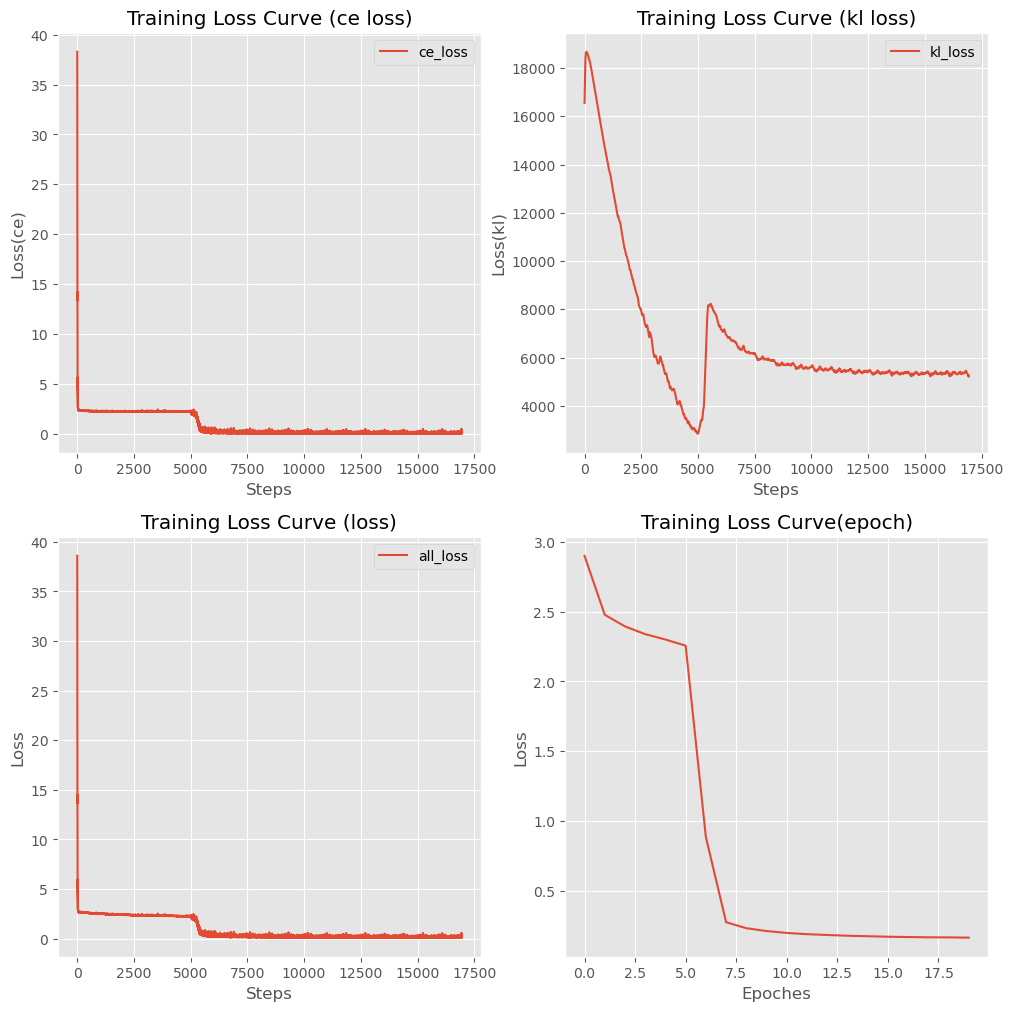

In [26]:
# Plotting after training
plt.style.use('ggplot')
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.plot(ce_losses, label='ce_loss')
plt.xlabel('Steps')
plt.ylabel('Loss(ce)')
plt.legend()
plt.title('Training Loss Curve (ce loss)')

plt.subplot(2,2,2)
plt.plot(kl_losses, label='kl_loss')
plt.xlabel('Steps')
plt.ylabel('Loss(kl)')
plt.legend()
plt.title('Training Loss Curve (kl loss)')

plt.subplot(2,2,3)
plt.plot(losses, label='all_loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curve (loss)')

plt.subplot(2,2,4)
plt.plot(epoch_losses)
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.title('Training Loss Curve(epoch)')
plt.savefig(os.path.join(result_dir,'Training Curve(epoch).png'))
plt.show()

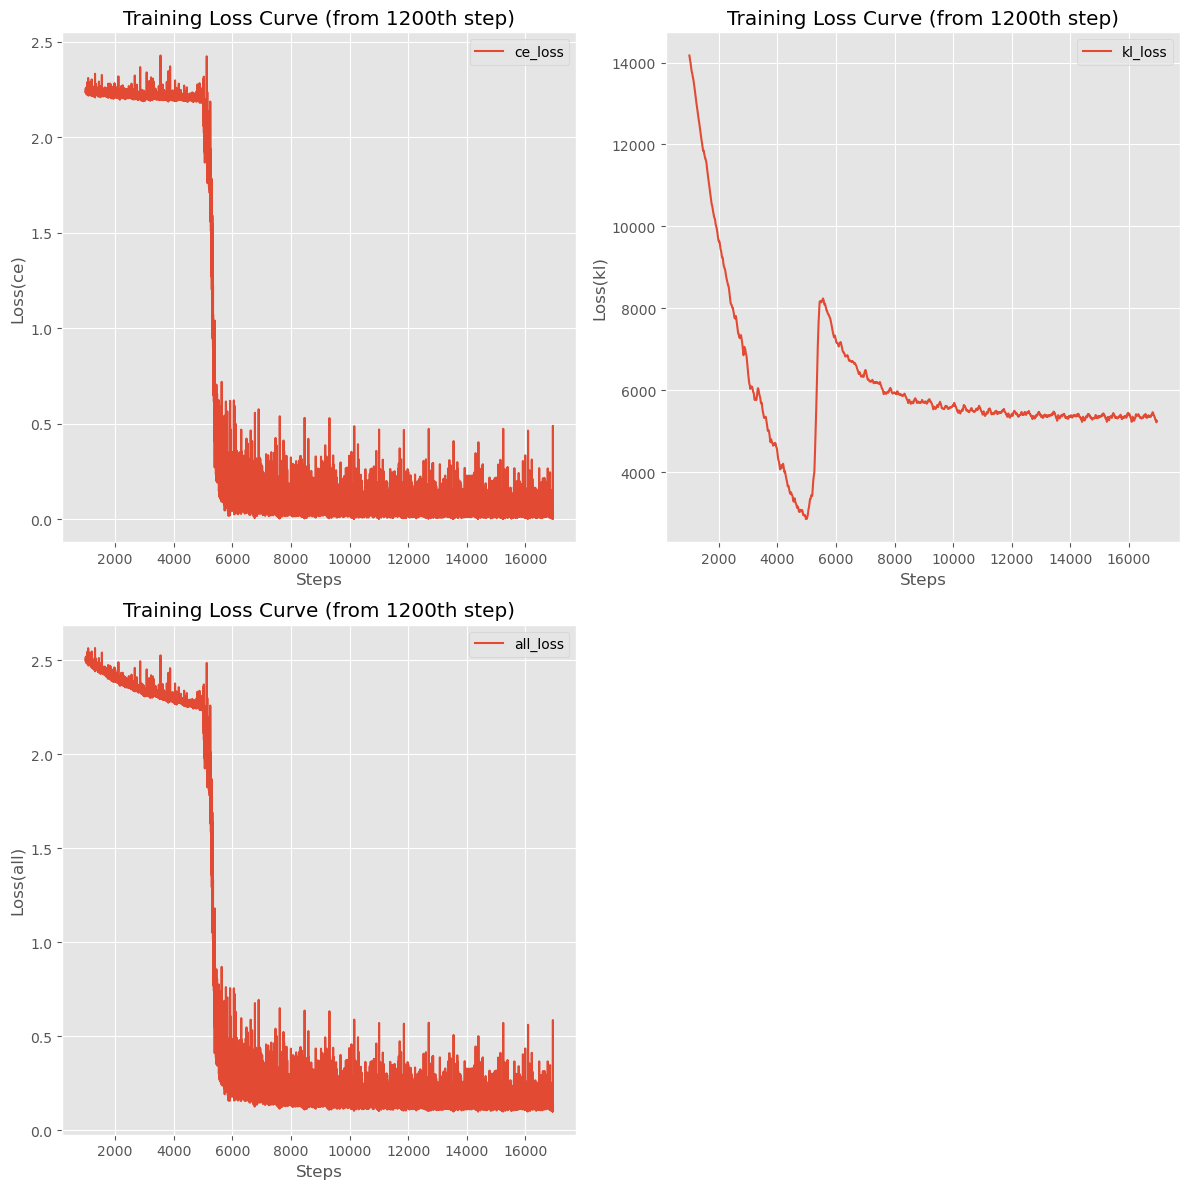

In [27]:
start_step = 1000
steps = range(start_step, start_step + len(ce_losses[start_step:]))
ce_losses_from_1200 = ce_losses[start_step:]
kl_losses_from_1200 = kl_losses[start_step:]
losses_from_1200 = losses[start_step:]

plt.style.use('ggplot')
plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
plt.plot(steps, ce_losses_from_1200, label='ce_loss')
plt.xlabel('Steps')
plt.ylabel('Loss(ce)')
plt.legend()
plt.title('Training Loss Curve (from 1200th step)')

plt.subplot(2,2,2)
plt.plot(steps, kl_losses_from_1200, label='kl_loss')
plt.xlabel('Steps')
plt.ylabel('Loss(kl)')
plt.legend()
plt.title('Training Loss Curve (from 1200th step)')

plt.subplot(2,2,3)
plt.plot(steps, losses_from_1200, label='all_loss')
plt.xlabel('Steps')
plt.ylabel('Loss(all)')
plt.legend()
plt.title('Training Loss Curve (from 1200th step)')

plt.tight_layout()
plt.show()

## 4. Test Model

### Uncertianty Quantification

In [28]:
def PredUncertainty(pred, type='predictive'):
    '''
    pred: [b_size, nruntest, class]
    '''
    pred = pred.detach().cpu()
    mean_pred = torch.mean(pred, axis=1).squeeze()
    
    uncertainty = -torch.sum(mean_pred*torch.log2(mean_pred), dim=-1)

    if type == 'predictive':
        return uncertainty

    elif type == 'epistemic':
        entropy_samplewise = - torch.sum(pred * torch.log2(pred), dim=-1)
        data_uncertainty =  torch.mean(entropy_samplewise, dim=-1).squeeze()
        
        model_uncertainty = uncertainty - data_uncertainty
        return model_uncertainty

### 4.0 Load model and test data

In [29]:
# Load model
model = BayesianMnistNet().to(device)
model_path = os.path.join(ck_dir, f'bnn_v1.pt')
model.load_state_dict(torch.load(model_path))

# Load test data
nruntest = 32
test_loader = DataLoader(test, batch_size=batch_size)
imgs, labels = next(iter(test_loader))
imgs, labels = imgs.to(device), labels.to(device)
single_img, single_label = imgs[0].unsqueeze(0), labels[0].item()

# Inference on single data
single_test_pred = torch.zeros(1, nruntest, 10).to(device)
model.eval()
with torch.no_grad():
    for _ in range(nruntest):
        single_test_pred[:, _, :] = F.softmax(model(single_img), dim=-1)

# Inference on batch data
test_pred = torch.zeros(batch_size, nruntest, 10).to(device)
with torch.no_grad():
    for _ in range(nruntest):
        test_pred[:, _, :] = F.softmax(model(imgs), dim=-1)

### 4.1 Qualitative Analysis

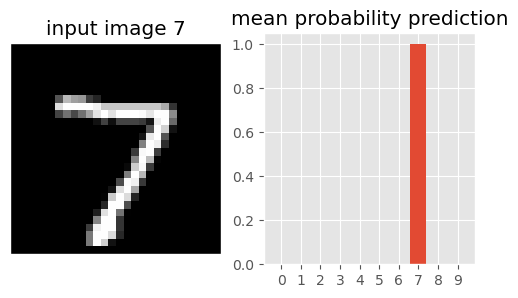

predictive uncertainty: 0.00039132963865995407
epistemic uncertainty: 3.545553772710264e-05


In [30]:
uncertainty_labels = ['predictive', 'epistemic']
uncertainty = [PredUncertainty(single_test_pred, 'predictive'), PredUncertainty(single_test_pred, 'epistemic')]
single_pred_mean = torch.mean(single_test_pred.squeeze(), dim=0)
single_pred_cpu = single_pred_mean.squeeze().detach().cpu().numpy()

single_img_cpu = single_img.squeeze().cpu()
plt.figure(figsize=(6,3 ))
plt.subplot(1,2,1)
plt.imshow(single_img_cpu, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title(f'input image {single_label}')

plt.subplot(1,2,2)
plt.bar(np.arange(10), single_pred_cpu)
plt.xticks(np.arange(10))
plt.title(f'mean probability prediction')

plt.show()
print(f'{uncertainty_labels[0]} uncertainty: {uncertainty[0]}')
print(f'{uncertainty_labels[1]} uncertainty: {uncertainty[1]}')

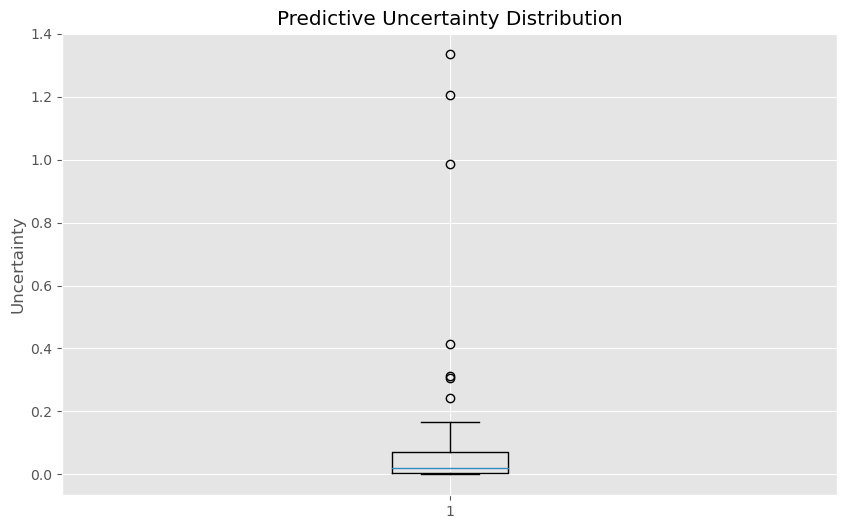

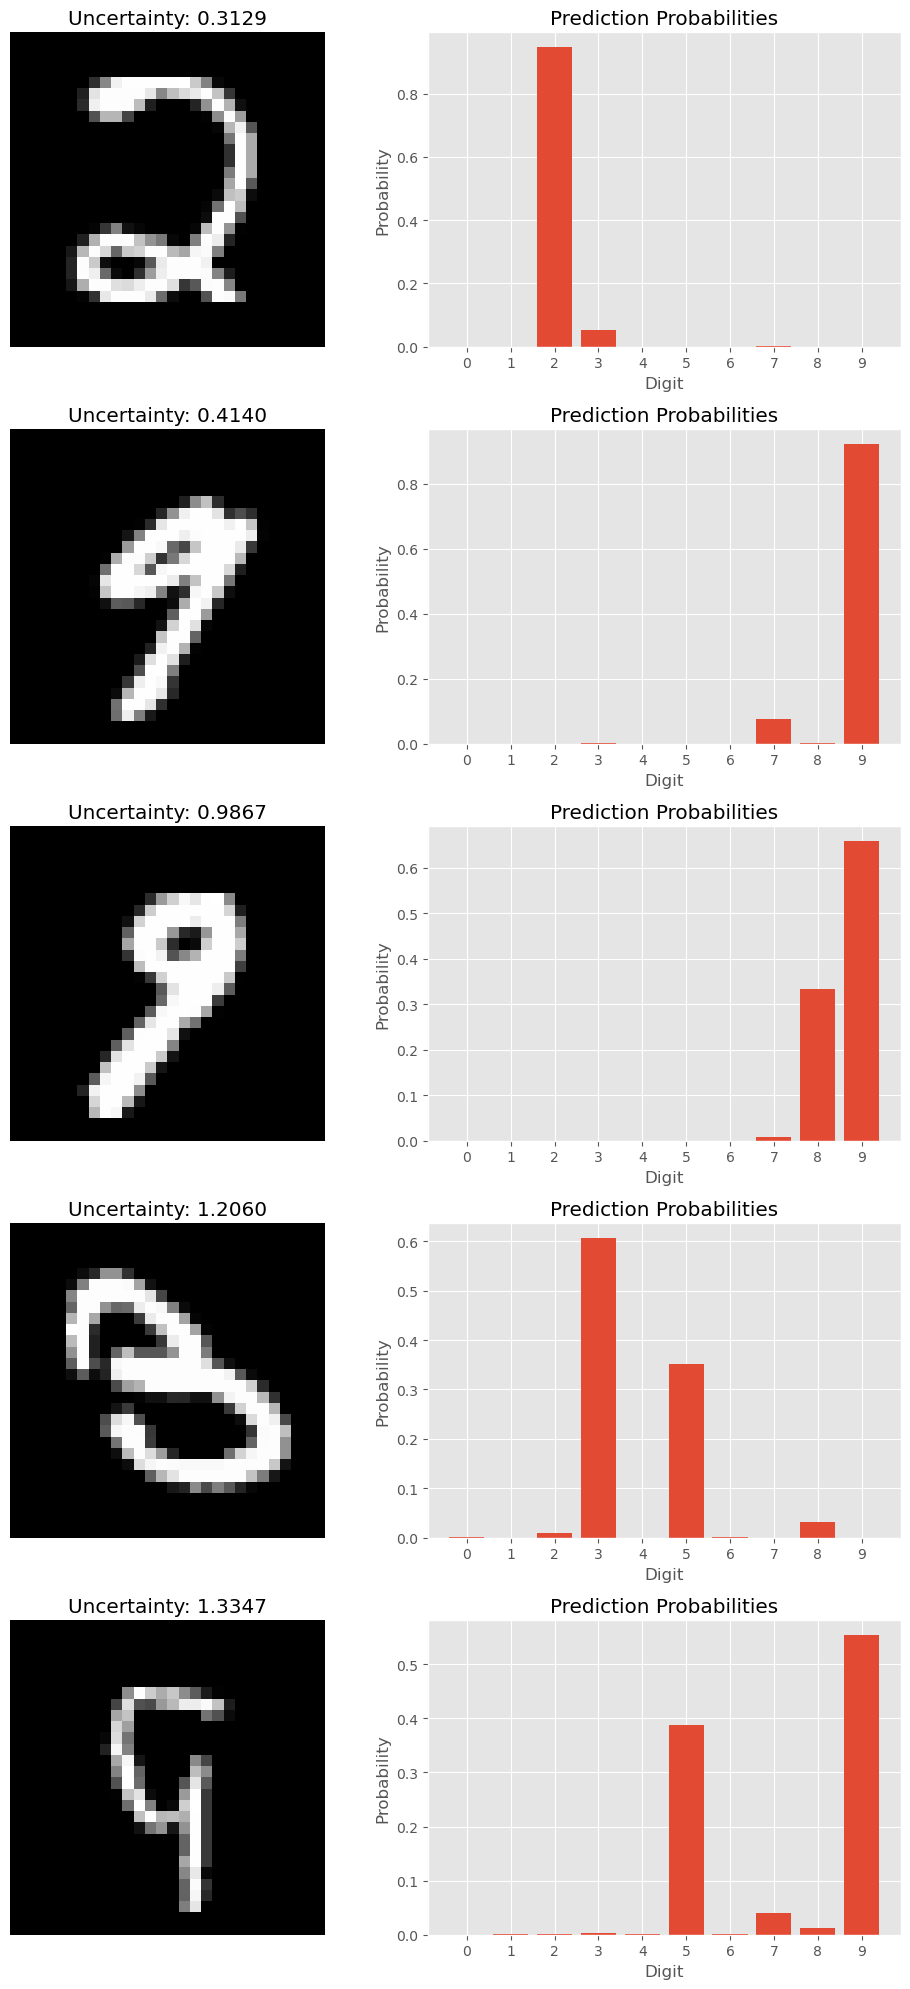

Uncertainties of top 5 images: [0.3129221  0.41403264 0.9867285  1.2060431  1.334674  ]


In [31]:
uncertainty_test = PredUncertainty(test_pred).detach()
uncertainty_test_np = uncertainty_test.cpu().numpy()

uncertainty_test_model = PredUncertainty(test_pred, type='epistemic').detach()
uncertainty_test_model_np = uncertainty_test.cpu().numpy()

# Plot a violin plot of predictive uncertainty
plt.figure(figsize=(10, 6))
plt.boxplot(x=uncertainty_test_np)
plt.title('Predictive Uncertainty Distribution')
plt.ylabel('Uncertainty')
plt.show()

# Select top 5 images with highest uncertainty for qualitative analysis
top_k = 5
top_k_indices = np.argsort(uncertainty_test_np)[-top_k:]

# Plot the images with highest uncertainty
plt.figure(figsize=(10, 20))
for i, idx in enumerate(top_k_indices):
    plt.subplot(top_k, 2, 2*i + 1)
    plt.imshow(imgs[idx].cpu().squeeze(), cmap='gray')
    plt.title(f'Uncertainty: {uncertainty_test[idx].item():.4f}')
    plt.axis('off')

    # Bar plot of the prediction probabilities for the image
    plt.subplot(top_k, 2, 2*i + 2)
    pred_probs = torch.mean(test_pred[idx], dim=0).detach().cpu().numpy()  # Mean prediction over runs
    plt.bar(range(10), pred_probs)
    plt.xlabel('Digit')
    plt.xticks(np.arange(10))
    plt.ylabel('Probability')
    plt.title('Prediction Probabilities')
plt.tight_layout()
plt.show()

# Print uncertainties for analysis
print(f"Uncertainties of top {top_k} images: {uncertainty_test_np[top_k_indices]}")

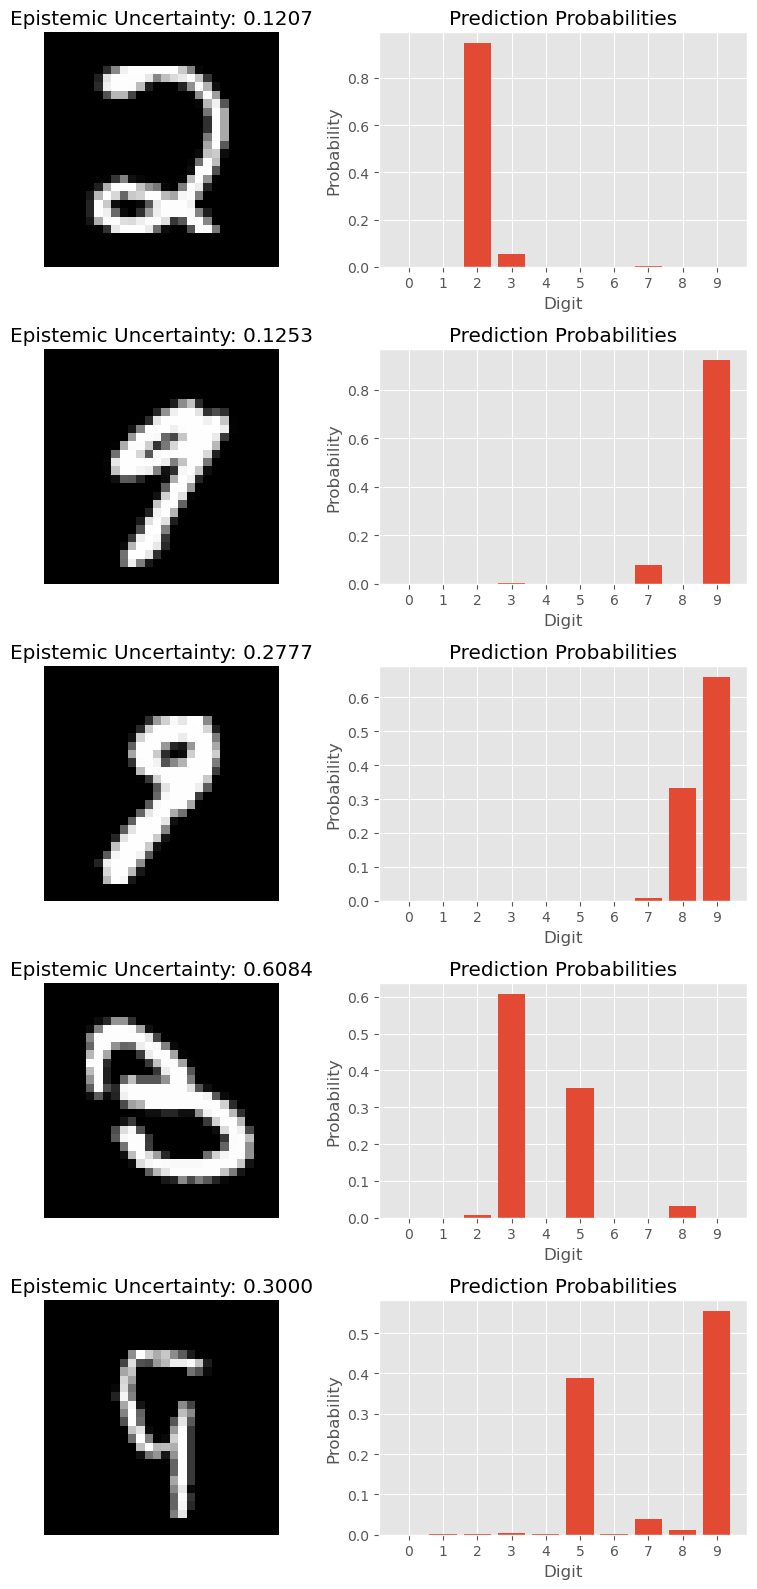

Uncertainties of top 5 images: [0.3129221  0.41403264 0.9867285  1.2060431  1.334674  ]


In [32]:
uncertainty_test_model = PredUncertainty(test_pred, type='epistemic').detach()
uncertainty_test_model_np = uncertainty_test.cpu().numpy()

# Select top 5 images with highest uncertainty for qualitative analysis
top_k = 5
top_k_indices = np.argsort(uncertainty_test_model_np)[-top_k:]

# Plot the images with highest uncertainty
plt.figure(figsize=(8, 16))
for i, idx in enumerate(top_k_indices):
    plt.subplot(top_k, 2, 2*i + 1)
    plt.imshow(imgs[idx].cpu().squeeze(), cmap='gray')
    plt.title(f'Epistemic Uncertainty: {uncertainty_test_model[idx].item():.4f}')
    plt.axis('off')

    # Bar plot of the prediction probabilities for the image
    plt.subplot(top_k, 2, 2*i + 2)
    pred_probs = torch.mean(test_pred[idx], dim=0).detach().cpu().numpy()  # Mean prediction over runs
    plt.bar(range(10), pred_probs)
    plt.xlabel('Digit')
    plt.xticks(np.arange(10))
    plt.ylabel('Probability')
    plt.title('Prediction Probabilities')
plt.tight_layout()
plt.show()

# Print uncertainties for analysis
print(f"Uncertainties of top {top_k} images: {uncertainty_test_model_np[top_k_indices]}")

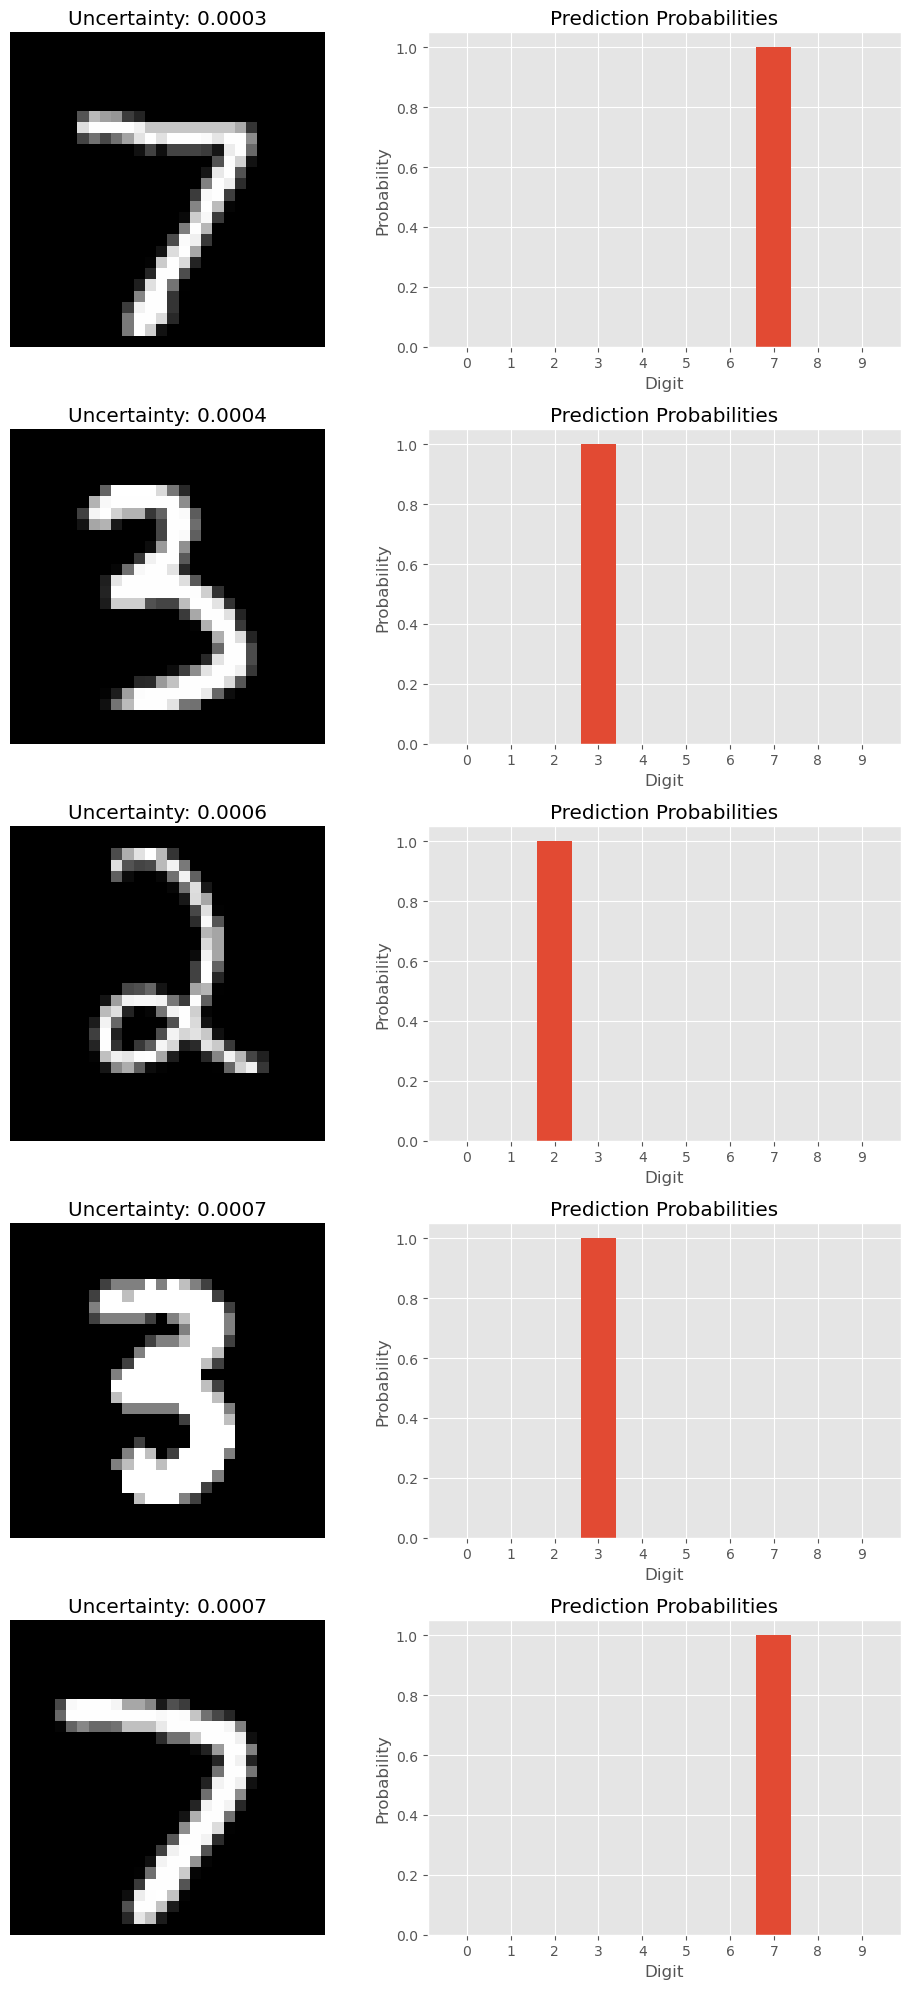

Uncertainties of top 5 images: [0.00031997 0.00037964 0.00056911 0.00065528 0.00069966]


In [33]:
# Select top 5 images with lowest uncertainty for qualitative analysis
top_k = 5
top_k_indices = np.argsort(uncertainty_test_np)[:top_k]

# Plot the images with lowest uncertainty
plt.figure(figsize=(10, 20))
for i, idx in enumerate(top_k_indices):
    plt.subplot(top_k, 2, 2*i + 1)
    plt.imshow(imgs[idx].cpu().squeeze(), cmap='gray')
    plt.title(f'Uncertainty: {uncertainty_test[idx].item():.4f}')
    plt.axis('off')

    # Bar plot of the prediction probabilities for the image
    plt.subplot(top_k, 2, 2*i + 2)
    pred_probs = torch.mean(test_pred[idx], dim=0).detach().cpu().numpy()  # Mean prediction over runs
    plt.bar(range(10), pred_probs)
    plt.xlabel('Digit')
    plt.xticks(np.arange(10))
    plt.ylabel('Probability')
    plt.title('Prediction Probabilities')
plt.tight_layout()
plt.show()

# Print uncertainties for analysis
print(f"Uncertainties of top {top_k} images: {uncertainty_test_np[top_k_indices]}")

### 4.1 Test on seen data